# OpFlow codomain 1D experiment
run ``1D_codomain_GP_prior`` first

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
import timeit

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## dataset parameters and preparation

In [3]:
ntrain = 30000
ndim = 128
batch_size = 512

nchannel = 2

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.2
nu_z = 1.5

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm
def GaussianProcess_1C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel=1):
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    #y_samples = gpr_model.sample_y(X, n_samples)
    
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim, n_samples, nchannel]).shape)        
    
    if return_kernel:
        return torch.tensor(y_samples), kernel(X)
    else:
        return torch.tensor(y_samples)

Starting up. Generating GRF samples
torch.Size([30000, 128, 2])


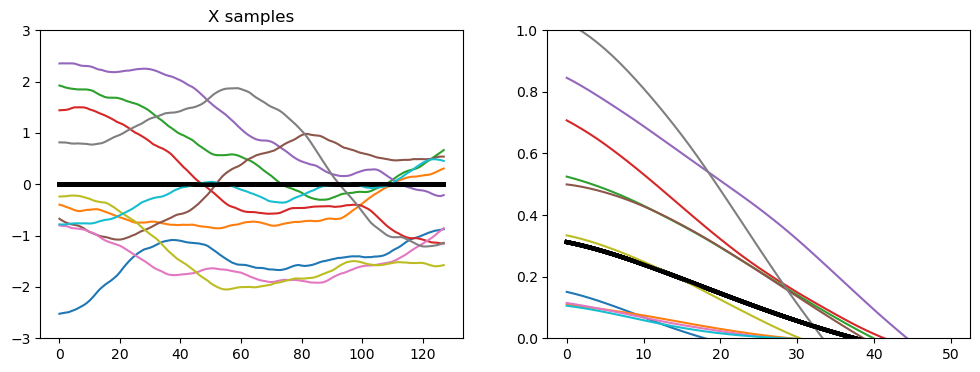

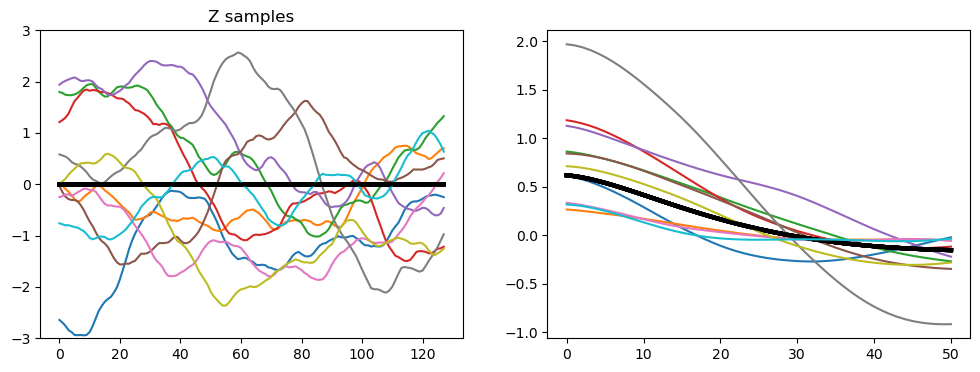

Finished sampling GRFs


In [5]:
print("Starting up. Generating GRF samples")

np.random.seed(10)
# nu = 0.5, the smaller, the less smooth (more rough) the approximated function is
x_train = GaussianProcess_1C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0, 2])
fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=(0,2))
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,:,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()

# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(ndim, length_scale_z, nu_z, ntrain*2, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0, 2])
#z_train = torch.randn(z_train.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
z_mean_true = z_train.mean(dim=(0,2))
z_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(z_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
# rename as z_loader
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True)

for i in range(10):
    #x = grf.sample(1)[0,:,0]
    z = z_train[i,:,0]
    ax[0].plot(z)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(z_mean_true, c='k', lw=3)
    ax[1].plot(z_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(z, nlag=50))
    #ax[1].set_ylim([0.0, 1.0])
    ax[0].set_title("Z samples")
plt.show()
print("Finished sampling GRFs")

### OpFlow model setup

In [6]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, n=x.size(-1))
        x = torch.fft.irfft(out_ft)
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv1d(int(in_channel), int(out_channel), 1)

    def forward(self,x):
        
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [7]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        #self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = pointwise_op(self.width, self.width) #
        
        self.w1 = pointwise_op(self.width, self.width) #
        
        self.w2 = pointwise_op(self.width, self.width) #
        
        self.w3 = pointwise_op(self.width, self.width) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=2)
        
        x = self.fc0(x)
        x = F.gelu(x)
               
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [8]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
            std = input.std(dim=(0,1)).unsqueeze(0).unsqueeze(1)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, modes, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.modes = modes
        self.width = width
        self.coupling = FNO1d(modes=self.modes, width=self.width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        #
        x = z
        x, log_actnorm = self.actnorm(x)
        
        """
        n_rep = x.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=x.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:x.shape[1]]
        mask_b = torch.logical_not(mask_a)
        # define the dimension
        x1 = x * mask_a[None,:,None] # x1 has the same shape of z, but for False in mask_a, values are replaced with 0
        x2 = x * mask_b[None,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
        """
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,0:1]
        x2 = x[:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
    
        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,0:1]
        z2 = z[:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], 2]).shape)
        log_scale = scale_shift[:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [10]:
class OpFlow(nn.Module):
    def __init__(self, modes, width, blocks, base_dist, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]

        self.bijectors = nn.ModuleList([
            AffineCoupling(modes=modes, width=width) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [11]:
lr = 5*1e-5
epochs = 600
reg_fac = 1

n_train_tot = int(ntrain/batch_size)
modes = ndim // 4
width = 64
#width = 128


blocks = 10
base_mu = torch.zeros(ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

## Validation

In [12]:
# load trained model
model = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)

# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = "../paper_saved_models/GP2GP_FNO_codomain_prior/1D_codomain_649_prior.pt"
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [13]:
G = model

In [14]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
nlag_eva = int(ndim//2)

x_pos = np.linspace(0, 1, ndim)
x_pos_acovf = x_pos[:nlag_eva]

nsample_eva = 5000

x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=nlag_eva-1)) for i in range(ntrain)]).mean(dim=0)

In [15]:
folder = "GP2GP_FNO_codomain_prior"
if not os.path.exists(f"../paper_pdf/{folder}"):
    os.makedirs(f"../paper_pdf/{folder}")

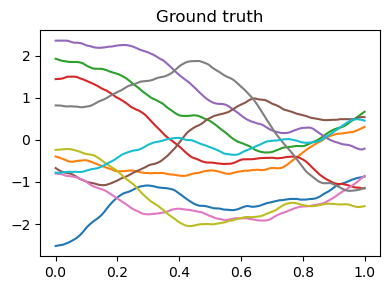

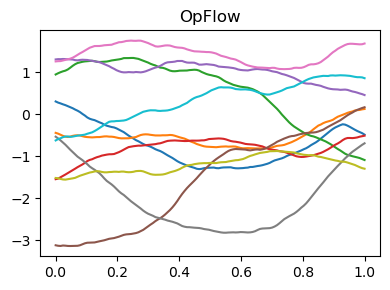

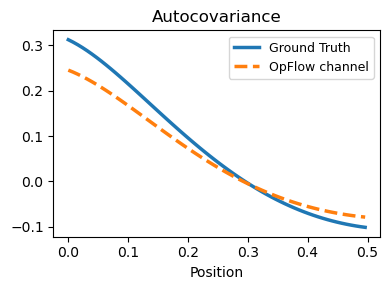

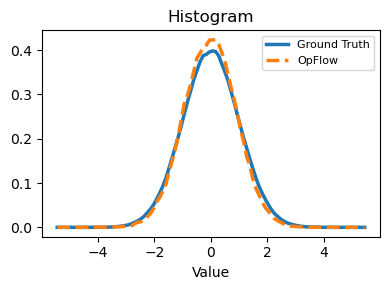

In [16]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
    Z = torch.cat([base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1)], axis=-1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    X_ground_truth = x_train[:10]

    #Z_alt = base_dist.rsample(sample_shape=(1000,))[:,:,None]
    Z_alt = torch.cat([base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1)], axis=-1)    

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)  
    
    x_hist_channel1, bin_edges_alt = X_alt[:,:,0].histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt[:,:,1].histogram(range=[-5.5,5.5], density=True)  
    
    # plot first ground truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
    plt.title('Ground truth')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,0]
        ax.plot(x_pos, x1)
    plt.title('OpFlow')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")

    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,1]
        ax.plot(x_pos, x1)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")
        
    """

    #x_mean_channel1 = X_alt[:,:,0].mean(dim=0)
    #x_mean_channel2 = X_alt[:,:,1].mean(dim=0)
    x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)
    x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow channel')
    #ax.plot(x_pos_acovf, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel')
    
    ax.set_xlabel('Position')
    ax.set_title('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')
    ax.set_xlabel('Value')
    ax.set_title('Histogram')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_hist.pdf")

## Regression

In [17]:
from sklearn.gaussian_process.kernels import WhiteKernel

In [18]:
for param in G.parameters():
    param.requires_grad = False

## Get the MAP for A

In [19]:
ndim = 128
lr = 1e-3 
epochs = 6000
noise_level = 0.01

pos_mask = torch.zeros(ndim)

pos_idx = np.random.choice(ndim, 6, replace=False)
#pos_idx = np.array([ 83, 112,  93,   4,  49,  15]) #used for the paper

pos_mask[pos_idx] = 1
#pos_mask[::int(ndim/8)] = 1
#pos_mask[-1] = 1 

pos_mask = (pos_mask==1)

u_obs_full = x_train[20:21,:,  :]

u_obs_part = u_obs_full[:,pos_mask,:].to(device)
noise_pattern =  torch.randn_like(u_obs_part) # freeze the noise for repeatable results
u_obs_part = u_obs_part + noise_pattern * np.sqrt(noise_level)


u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

In [20]:
u_obs_part_detach.shape

torch.Size([1, 6, 2])

In [ ]:
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=3, c='#1f77b4')
plt.scatter(x_range[pos_mask], u_obs_part_detach[:,:,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.title('1D Resolution 128', fontsize=12)
plt.legend()

## Ground Truth GP
# u shouldn't add the white kernel ( do that only in estimation noisy level, build a second GP whith alpha)
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x) 

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part[:,:,0].squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 8))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(x_range[pos_mask], u_obs_part_detach[:,:,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=2, c='r')
ax.legend()

## Get the MAP 

In [22]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,ndim, 2))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inverse(self.a_target)
        
    def logp(self):
        u = self.target_u()
        a, log_pa, log_det = self.G(u)
        return log_pa+log_det

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:,pos_mask,:])**2)/noise_level
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_u.u_target[:,pos_mask,:])**2)/noise_level
        loss2 = reg_opflow_a.logp()
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses


In [23]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [ ]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

## Validation of the MAP result

In [25]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [26]:
u_opflow = reg_opflow_a.target_u().data.squeeze().cpu().detach()
u_opflow_old = u_opflow.clone() #save a copy
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

In [27]:
u_obs_part.shape

torch.Size([1, 6, 2])

In [28]:
## Ground Truth GP
#test_length_scale = 0.5
#test_nu = 1.5
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds=(1e-1, 10.0), nu=nu_x)  #+ WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  #+ WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part[:,:,0].squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)


## second channel
gpr_model_ground_truth_channel2 = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

y_obs_channel2 = u_obs_part[:,:,1].squeeze().detach().cpu().numpy()
gpr_model_ground_truth_channel2 = gpr_model_ground_truth_channel2.fit(x_obs, y_obs_channel2) #update the GP model 

y_mean_channel2, y_std_channel2 = gpr_model_ground_truth_channel2.predict(X, return_std=True)
y_samples_channel2 = gpr_model_ground_truth_channel2.sample_y(X, 5)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.ones(100))
#axs[0].plot(losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Negative Log likelihood')

axs[1].plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=3, c='#1f77b4')
axs[1].scatter(x_range[pos_mask], u_obs_part_detach[:,:,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
axs[1].plot(x_range, u_opflow[:,0], label='OpFlow', lw=2, c='#ff7f00')
axs[1].set_title('1D Resolution 128', fontsize=12)
axs[1].legend()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 4))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x_range, u_opflow[:,0], label='OpFlow', ls='--', lw=2, c='#ff7f00')
plt.scatter(x_range[pos_mask], u_obs_part_detach[:,:,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=2, c='r')
ax.legend()
#ax.set_ylim([-3, 3])
#plt.savefig(f"paper_pdf/{folder}_MAP_regressoin.pdf")

## also plot the second chanel

In [ ]:
## second channel 
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.ones(100))
#axs[0].plot(losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Negative Log likelihood')

axs[1].plot(x_range, u_obs_full[:,1], label='Ground Truth full', lw=3, c='#1f77b4')
axs[1].scatter(x_range[pos_mask], u_obs_part_detach[:,:,1], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
axs[1].plot(x_range, u_opflow[:,1], label='OpFlow', lw=2, c='#ff7f00')
axs[1].set_title('1D Resolution 128', fontsize=12)
axs[1].legend()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 4))
for idx, single_prior in enumerate(y_samples_channel2.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean_channel2, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean_channel2 - y_std_channel2,
    y_mean_channel2 + y_std_channel2,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x_range, u_opflow[:,1], label='OpFlow', ls='--', lw=2, c='#ff7f00')
plt.scatter(x_range[pos_mask], u_obs_part_detach[:,:,1], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,1], label='Ground Truth full', lw=2, c='r')
ax.legend()
#ax.set_ylim([-3, 3])
#plt.savefig(f"paper_pdf/{folder}_MAP_regressoin.pdf")

## also plot the second chanel

## SGLD sampling

In [28]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_SGLD

import sampling_SGLD.samplers


import sampling_SGLD.SGLD
reload(sampling_SGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_SGLD.samplers)
from sampling_SGLD.samplers import LangevinDynamics

import copy
from tqdm import tqdm

/tmp/ipykernel_2709953/2771402357.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Regression on $\mathcal{A}$ Gaussian space

In [29]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [30]:
a_opflow_copy.shape

torch.Size([1, 128, 2])

In [31]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood
    u_from_a = G.inverse(a)
    loss1 = -0.5*torch.sum((u_obs_part - u_from_a[:,pos_mask,:])**2)/noise_level
    
    _, log_pa, log_det = G(u_from_a) 
    loss2 = log_pa + log_det
    
    loss = -(loss1 + loss2) 
    return loss

In [106]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1

max_itr = int(4e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-5,
                                     lr_final=4e-5,
                                     max_itr=max_itr,
                                     device=device,
                                     base_dist = base_dist,
                                     temperature = temperature,
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [1:22:55<00:00,  8.04it/s]


In [ ]:
## regression using GP on A 

In [107]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
u_samples_all = G.inverse(a_samples_all)

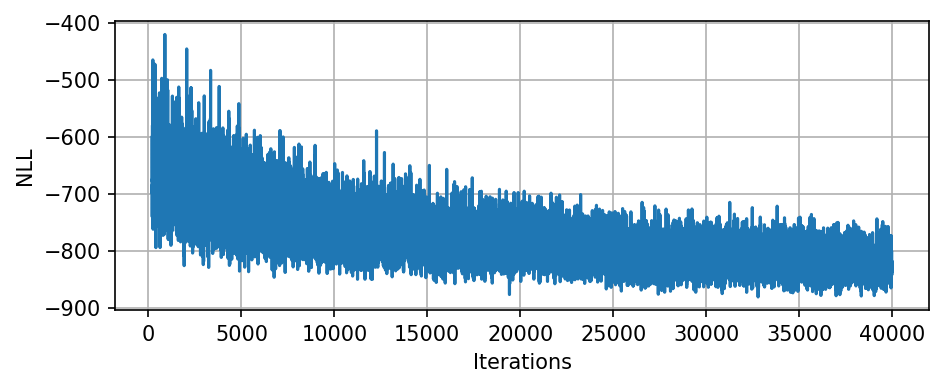

In [108]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

## Get target U

In [120]:
est_samples = u_samples_all.detach().cpu().numpy()

In [121]:
est_samples = est_samples[200:]

In [122]:
x = np.linspace(0, 1, ndim)
X = x.reshape(-1, 1)

In [112]:
est_samples.shape

(4000, 128, 2)

Text(0, 0.5, 'value')

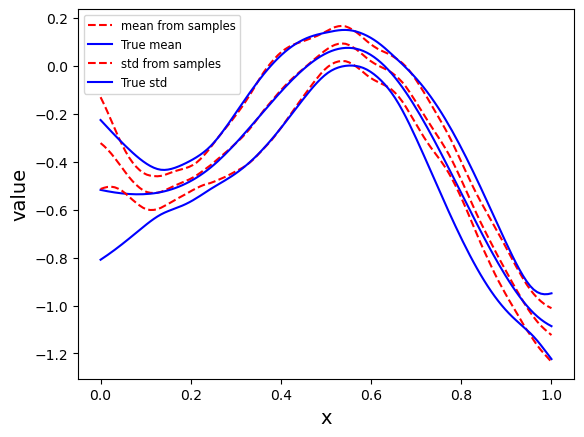

In [123]:
sample_std = np.std(est_samples[:,:,0], axis=0).squeeze()
sample_mean = np.mean(est_samples[:,:,0], axis=0).squeeze()

plt.plot(x, sample_mean, c='r', ls='--', label='mean from samples')
plt.plot(x, y_mean, c='b', label='True mean')
plt.plot(x, sample_mean-sample_std, c='r', ls='--', label='std from samples')
plt.plot(x, sample_mean+sample_std, c='r', ls='--')
plt.plot(x, y_mean-y_std,c='b', label='True std' )
plt.plot(x,y_mean+y_std, c='b')
plt.legend(fontsize='small')
plt.xlabel('x', fontsize=14)
plt.ylabel('value', fontsize=14)
#plt.savefig(f"paper_pdf/{folder}_SGLD_mean_std.pdf")

## Plot

In [126]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, len(est_samples)).T

opflow_std = np.std(est_samples, axis=0).squeeze()
opflow_mean = np.mean(est_samples, axis=0).squeeze()

sample_idx = np.random.choice(len(est_samples), 5, replace=False)

samples_opflow = est_samples[sample_idx].squeeze()
samples_ground_truth = y_samples[sample_idx].squeeze()

In [127]:
saved_folder = 'GP2GP_codomain_reg'
if not os.path.exists(f"Regression_results/{saved_folder}"):
    os.makedirs(f"Regression_results/{saved_folder}")

In [128]:
u_obs_full.shape

torch.Size([128, 2])

In [134]:
samples_opflow.shape

(5, 128, 2)

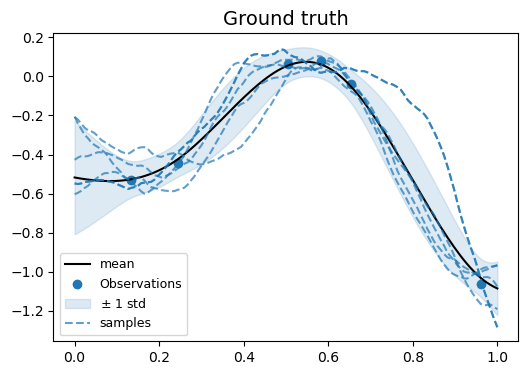

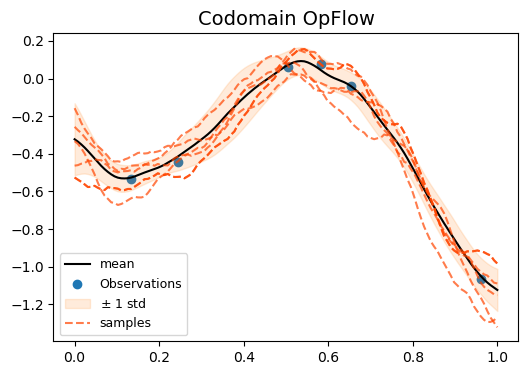

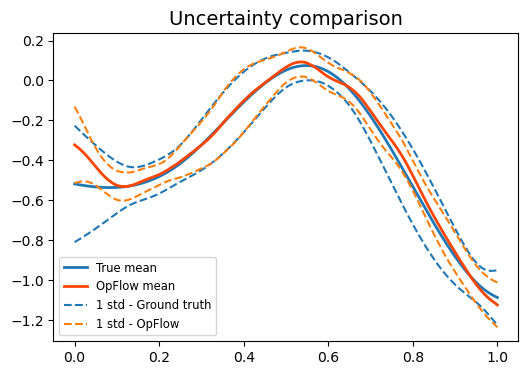

In [136]:
## Figure 1 (Ground Truth : mean + std + samples)
## Figure 2 (OpFlow : mean + std _samples)
## Figure 3 (Mean and Std comparision) 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, y_mean, c='k', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask,0],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.15, color="#1f77b4", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_ground_truth):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4', label=f"samples")

ax.set_title('Ground truth', fontsize=14)       
ax.legend(loc='lower left', fontsize=9)
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_gt.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, opflow_mean[:,0], c='black', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask,0],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, (opflow_mean - opflow_std)[:,0], (opflow_mean + opflow_std)[:,0], alpha=0.15, color="#ff7f0e", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_opflow[:,:,0]):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500', label=f"samples")

ax.set_title('Codomain OpFlow', fontsize=14)
#ax.set_title('OpFlow - Regression on A, white noise', fontsize=14)
ax.legend(loc='lower left', fontsize=9)
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_opflow.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('Uncertainty comparison', fontsize=14)
ax.plot(x_range, y_mean, lw=2, c='#1f77b4', label='True mean')
ax.plot(x_range, opflow_mean[:,0], lw=2, c='#FF4500', label='OpFlow mean')
#ax.plot(x_range, u_opflow_copy.squeeze(), lw=2, c='k', label='OpFlow MAP' )
ax.plot(x, y_mean-y_std,ls='--',c='#1f77b4', label=r'1 std - Ground truth' )
ax.plot(x,y_mean+y_std,ls='--', c='#1f77b4')
#ax.plot(x, y_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 $\sigma$ - OpFlow')
#ax.plot(x, y_mean+opflow_std, c='#ff7f0e', ls='--')
ax.plot(x, (opflow_mean-opflow_std)[:,0], c='#ff7f0e', ls='--', label=r'1 std - OpFlow')
ax.plot(x, (opflow_mean+opflow_std)[:,0], c='#ff7f0e', ls='--')
ax.legend(fontsize='small')
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_uncertainty.pdf")

### generate hdf5 file for saving the info

In [137]:
import h5py
f = h5py.File(f"Regression_results/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=pos_idx)
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()